In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl

### Jobwise energy data

In [2]:
energy = pd.read_csv('/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_perhost_jobs_full/jobwise_combine.csv')

### Jobwise power data

In [3]:
files = glob.glob('/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/power_jobwise_10s/*.csv')
temp_pwr = []
[temp_pwr.append(pd.read_csv(f,index_col=None)) for f in files]
power = pd.concat(temp_pwr, ignore_index=True)


In [4]:
energy_df = energy.loc[:,['allocation_id','energy','num_nodes','job_domain']]
energy_df['node_hours'] = (energy_df['num_nodes']*energy['job_time'])/3600
power_df = power.loc[:,['allocation_id','max_sum_inp','max_sum_top']]
power_energy = energy_df.merge(power_df)

### Classification by scheduling

In [5]:
job_node_class = [(power_energy['num_nodes']<=45),
                (power_energy['num_nodes']>45)&(power_energy['num_nodes']<=91),
                (power_energy['num_nodes']>91)&(power_energy['num_nodes']<=921),
                (power_energy['num_nodes']>921)&(power_energy['num_nodes']<=2764),
                (power_energy['num_nodes']>2764)]


class_values = ['5','4','3','2','1']
power_energy['Class'] = np.select(job_node_class,class_values)


In [6]:
plot_df = power_energy[power_energy['energy']>=0]
plot_df['energy'] = plot_df['energy']+1
plot_df['max_sum_inp'] = plot_df['max_sum_inp']+1

<ipython-input-6-6cd1d7c4d6c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['energy'] = plot_df['energy']+1
<ipython-input-6-6cd1d7c4d6c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['max_sum_inp'] = plot_df['max_sum_inp']+1


In [7]:
plot_df['log_energy'] = np.log10(plot_df['energy'])
plot_df['log_max_sum_inp'] = np.log10(plot_df['max_sum_inp'])
#remove 0 energy and 0 power points as anomalies
plot_df = plot_df[(plot_df['log_max_sum_inp'] > 0)&(plot_df['log_energy'] > 0)]

<ipython-input-7-030f195b0830>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_energy'] = np.log10(plot_df['energy'])
<ipython-input-7-030f195b0830>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_max_sum_inp'] = np.log10(plot_df['max_sum_inp'])


In [8]:
values_nc = ['5','4','3','2','1']

job_type = [(plot_df['Class']=='5')|(plot_df['Class']=='4')|(plot_df['Class']=='3'),
                (plot_df['Class']=='2')|(plot_df['Class']=='1')]


values = ['small','large']
plot_df['job_type'] = np.select(job_type,values)

### Seaborn publication style

In [9]:

%matplotlib inline

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

### Plot

<Figure size 1000x750 with 0 Axes>

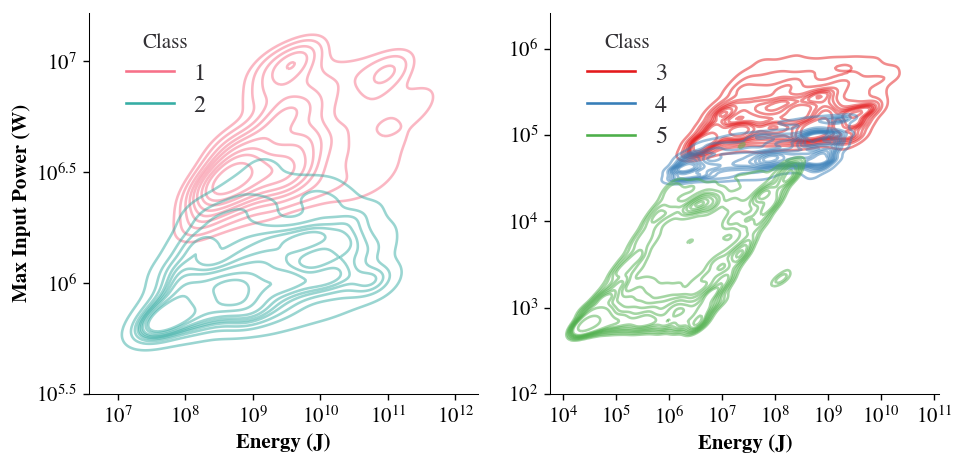

In [30]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()

sns.despine(top=False, right=False)
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'legend.frameon':False, 
                      'legend.fancybox':False, 'axes.labelweight':"bold"})

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8,4))

sns.kdeplot(ax=axes[1],x='log_energy', y='log_max_sum_inp',hue='Class',
            data=plot_df[plot_df['job_type']=='small'].iloc[:,:],alpha=0.5,
            palette="Set1", hue_order=['3','4','5'],legend=True, common_norm=False)

axes[1].set_xticks([4,5,6,7,8,9,10,11])
axes[1].set_xticklabels(["$10^4$", "$10^5$", "$10^6$", "$10^7$", "$10^8$", "$10^9$", "$10^{10}$", "$10^{11}$"])
axes[1].set_yticks([2,3,4,5,6])
axes[1].set_yticklabels(["$10^2$", "$10^3$", "$10^4$", "$10^5$", "$10^6$"])

axes[1].legend_.set_bbox_to_anchor((0.05, 0.99))
axes[1].legend_._set_loc(2)
axes[1].legend_.get_title().set_fontsize(12)
axes[1].set_xlabel("Energy (J)",fontweight='bold')
axes[1].set(ylabel=None)

sns.kdeplot(ax=axes[0], x='log_energy', y='log_max_sum_inp',hue='Class',
           data=plot_df[plot_df['job_type']=='large'].iloc[:,:],
            alpha=0.5,palette="husl", hue_order=['1','2'], common_norm=False)

axes[0].legend_.set_bbox_to_anchor((0.05, 0.99))
axes[0].legend_._set_loc(2)
axes[0].legend_.get_title().set_fontsize(12)
axes[0].set_xticks([7,8,9,10,11,12])

axes[0].set_xticklabels(["$10^7$", "$10^8$", "$10^9$", "$10^{10}$", "$10^{11}$", "$10^{12}$"])
axes[0].set_yticks([5.5,6,6.5,7])
axes[0].set_yticklabels(["$10^{5.5}$", "$10^6$", "$10^{6.5}$", "$10^7$"])
axes[0].set_xlabel("Energy (J)",fontweight='bold')
axes[0].set_ylabel("Max Input Power (W)",fontweight='bold')

fig.tight_layout()


In [31]:
fig.savefig("../plots/energy_vs_max_input_power_kde.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

## 